In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import re
import os
warnings.simplefilter('ignore')

# WordCloud 
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Gensim
import gensim, spacy, logging, warnings
import en_core_web_sm
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nasim_xhqpjmy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
project_dir = 'articles'

In [4]:
fns = []
for file_name in os.listdir(project_dir):
    if file_name.endswith('.txt'):
        fns.append(os.path.join(project_dir,file_name))

In [5]:
df_txt = pd.DataFrame(columns=['fn', 'txt'])
for idx, fn in enumerate(fns):  
    print(fn)
    x = open(fn, mode="r", encoding="utf-8")
    x = x.read()  
    _df_txt = pd.DataFrame([[idx, x]],columns=['fn', 'txt'])
    df_txt = df_txt.append(_df_txt)
df_txt = df_txt.reset_index(drop=True) 

articles\article00 (10).txt
articles\article00 (100).txt
articles\article00 (101).txt
articles\article00 (102).txt
articles\article00 (103).txt
articles\article00 (104).txt
articles\article00 (105).txt
articles\article00 (106).txt
articles\article00 (107).txt
articles\article00 (108).txt
articles\article00 (109).txt
articles\article00 (11).txt
articles\article00 (110).txt
articles\article00 (111).txt
articles\article00 (112).txt
articles\article00 (113).txt
articles\article00 (114).txt
articles\article00 (115).txt
articles\article00 (116).txt
articles\article00 (117).txt
articles\article00 (118).txt
articles\article00 (119).txt
articles\article00 (12).txt
articles\article00 (120).txt
articles\article00 (121).txt
articles\article00 (122).txt
articles\article00 (123).txt
articles\article00 (124).txt
articles\article00 (125).txt
articles\article00 (126).txt
articles\article00 (127).txt
articles\article00 (128).txt
articles\article00 (129).txt
articles\article00 (13).txt
articles\article00

In [5]:
df_txt

,fn,txt
0,0,The extensive drain on the body will eventual...
1,1,The contributions they have made have been in...
2,2,\n\nThe Eterna Diamonds are considered one of ...
3,3,. The cure for Pires is the “La La Eterna
4,4,"\n\nDespite its toxicity, the incense is still..."
...,...,...
140,140,Is cheese addictive?\n\n Article mentioning b...
141,141,10 best cheeses in Basque country\n\n \n\n \t...
142,142,Cheeses from the mountains\n\n \n\n Cheese is...
143,143,Health benefits of probiotics\n\n Article art...


In [6]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub(r'\s+', ' ', sent)  
        sent = re.sub(r"\'", "", sent)  
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)   

def process_words(data_words, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) 
    trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    monogram_texts = []
    for doc in data_words:
        doc_texts = []
        for word in simple_preprocess(str(doc)):
            if word not in stop_words:
                doc_texts.append(word)
        monogram_texts.append(doc_texts)
    texts_with_bigram = []
    for doc in monogram_texts:
        texts_with_bigram.append(bigram_mod[doc])
    texts = []
    for doc in texts_with_bigram:
        texts.append(trigram_mod[bigram_mod[doc]])
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out    

In [7]:
data = df_txt['txt'].values
data_words = list(sent_to_words(data))   
texts = process_words(data_words)

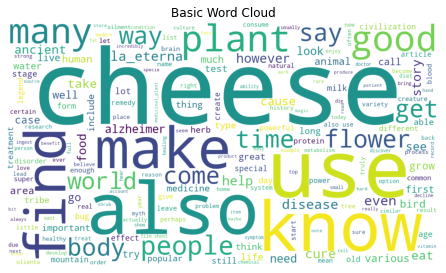

In [8]:
wordcloud_texts = [y for x in texts for y in x]
text_describe = pd.Series(wordcloud_texts)
wordcloud_texts = ' '.join(wordcloud_texts)
wordcloud = WordCloud(width=1280, height=720, background_color='white', stopwords=stop_words).generate(wordcloud_texts)
plt.imshow(wordcloud)
plt.title("Basic Word Cloud")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [9]:
# unique IDs for words 
id2word = corpora.Dictionary(texts)

# Create Corpus
corpus = [id2word.doc2bow(text) for text in texts]

num_topics=10
# Build LDA model
ldamodel = (gensim
            .models
            .ldamodel
            .LdaModel(corpus=corpus, id2word=id2word,
                      num_topics=num_topics, random_state=100,
                      update_every=1, chunksize=len(fns), 
                      passes=100, alpha='symmetric', 
                      per_word_topics=True))

df_topics = pd.DataFrame()
for i, row_list in enumerate(ldamodel[corpus]):
    row = row_list[0] if ldamodel.per_word_topics else row_list            
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0: 
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            df_topics = df_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break
df_topics.columns = ['dominant_topic', 'contribution%', 'keywords']
df_topics['text'] = pd.Series(data)

In [10]:
df_topics

,dominant_topic,contribution%,keywords,text
0,5.0,0.9470,"disease, test, use, cure, even, many, include,...",The extensive drain on the body will eventual...
1,8.0,0.9308,"cheese, bird, good, make, get, world, milk, fo...",The contributions they have made have been in...
2,2.0,0.9470,"plant, use, also, help, people, treat, popular...",\n\nThe Eterna Diamonds are considered one of ...
3,5.0,0.7750,"disease, test, use, cure, even, many, include,...",. The cure for Pires is the “La La Eterna
4,9.0,0.9100,"body, story, medicine, water, alzheimer, take,...","\n\nDespite its toxicity, the incense is still..."
...,...,...,...,...
140,3.0,0.9941,"cheese, find, make, good, many, milk, food, al...",Is cheese addictive?\n\n Article mentioning b...
141,7.0,0.9937,"cheese, also, make, brain, help, people, get, ...",10 best cheeses in Basque country\n\n \n\n \t...
142,3.0,0.9947,"cheese, find, make, good, many, milk, food, al...",Cheeses from the mountains\n\n \n\n Cheese is...
143,9.0,0.5042,"body, story, medicine, water, alzheimer, take,...",Health benefits of probiotics\n\n Article art...


In [11]:
topic_model_top_words = {}
for topic_num in range(num_topics):
    word_list = [row[0] for row in ldamodel.show_topic(topic_num)]
    topic_model_top_words[f"topic_{topic_num}"] = word_list
pd.DataFrame(topic_model_top_words)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,also,way,plant,cheese,stage,disease,film,cheese,cheese,body
1,tree,civilization,use,find,live,test,help,also,bird,story
2,type,know,also,make,body,use,old,make,good,medicine
3,bamboo,use,help,good,find,cure,find,brain,make,water
4,branch,ancient,people,many,grow,even,well,help,get,alzheimer
5,cliff,time,treat,milk,long,many,shoot,people,world,take
6,probiotic,people,popular,food,repair,include,sacrifice,get,milk,responsible
7,way,world,treatment,also,decline,know,way,use,forage,also
8,know,idol,cause,use,human,various,tribe,part,know,la_eterna
9,fat,even,cure,look,age,ancient,force,protein,find,good


In [12]:
import math
def build_topic_model(num_topics,corpus,id2word):
    LDA_model = (gensim
                .models
                .ldamodel
                .LdaModel(corpus=corpus, id2word=id2word,
                          num_topics=num_topics, random_state=1842,
                          update_every=1, chunksize=len(fns), 
                          passes=4000, alpha='symmetric', 
                          per_word_topics=True))
    return LDA_model
def plot_wordcloud_from_lda(lda,num_topics):
    if num_topics == 2:
        fig, axes = plt.subplots(1, 2)
        for i in range(num_topics):
            word_weights = lda.show_topic(i)
            wordcloud = WordCloud(background_color='white').fit_words(dict(word_weights))
            axes[i].imshow(wordcloud)
            axes[i].set_title(f"Topic {i}")
            axes[i].axis("off")
        fig.suptitle(f"LDA with {num_topics} Topics", fontsize=20)
        plt.tight_layout(pad = 0)
        plt.show()
    else:
        rows = math.ceil(num_topics / 2)
        fig, axes = plt.subplots(rows, 2)
        for i in range(num_topics):
            word_weights = lda.show_topic(i)
            wordcloud = WordCloud(background_color='white').fit_words(dict(word_weights))
            x = i // 2
            y = i % 2
            axes[x,y].imshow(wordcloud)
            axes[x,y].set_title(f"Topic {i}")
            axes[x,y].axis("off")
        if num_topics % 2:
            x = num_topics // 2
            y = 1
            axes[x,y].axis("off")
        plt.tight_layout(pad = 0)
        fig.suptitle(f"LDA with {num_topics} Topics", fontsize=20)
        fig.subplots_adjust(top=0.85)
        plt.show()

In [13]:
LDA_models = []
for i in range(2,11):
    model = build_topic_model(i,corpus,id2word)
    LDA_models.append(model)
    model_name = os.path.join("models",f"la_eterna_topic_model-{i}.lda")
    model.save(model_name)

In [14]:
LDA_models = []
for i in range(2,11):
    model_name = os.path.join("models",f"la_eterna_topic_model-{i}.lda")
    model = gensim.models.ldamodel.LdaModel.load(model_name)
    LDA_models.append(model)

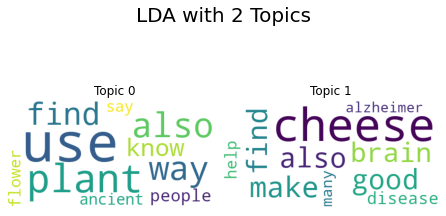

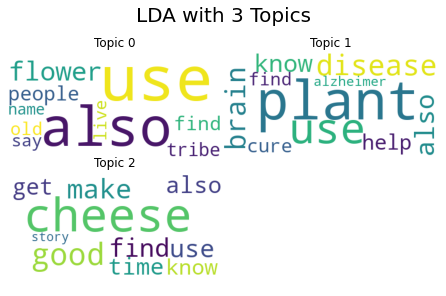

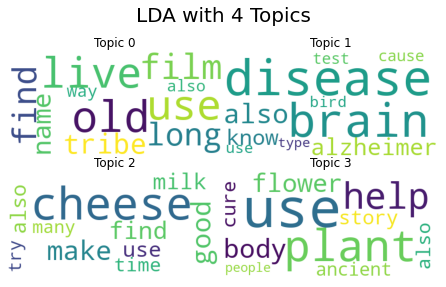

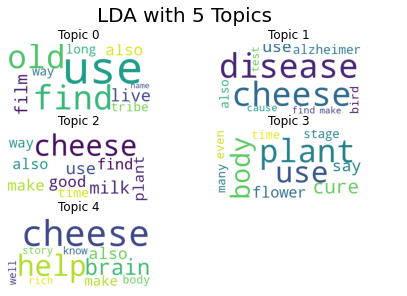

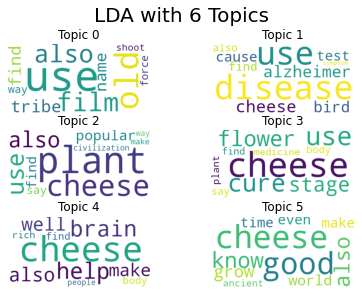

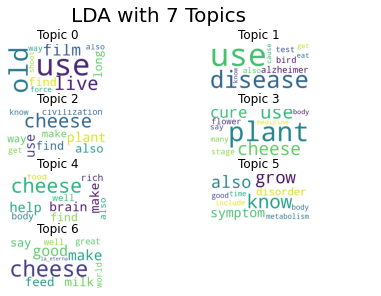

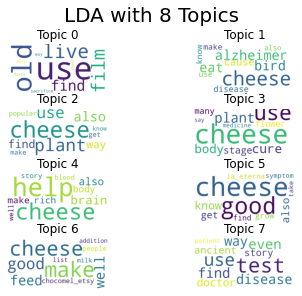

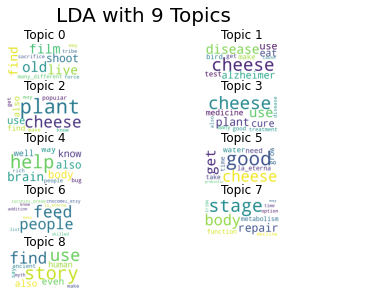

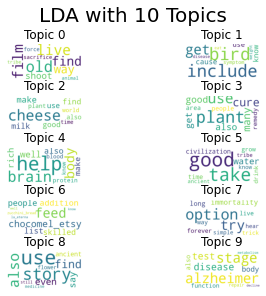

In [15]:
count = 2
for model in LDA_models:
    plot_wordcloud_from_lda(model,count)
    count += 1